In [47]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [48]:
!ls german-traffic-signs/

signnames.csv
test.p
train.p
valid.p


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2


from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline

In [50]:
np.random.seed(0)

In [51]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [52]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [53]:
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [54]:
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [55]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

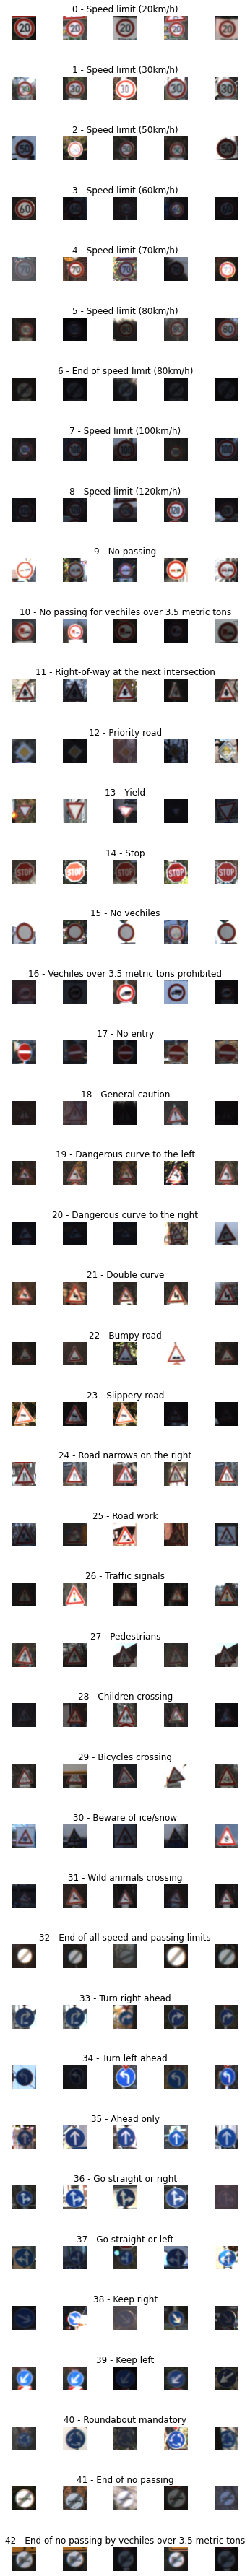

In [56]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))
            

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


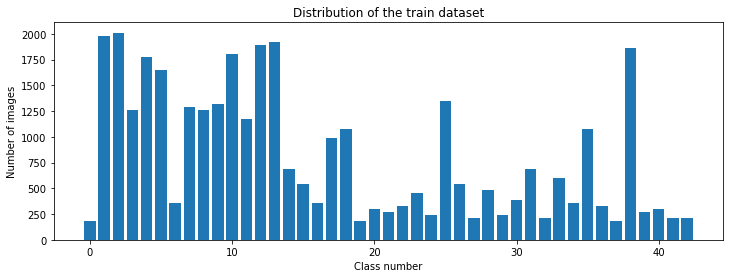

In [57]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


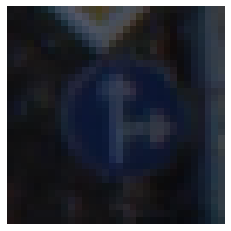

In [58]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


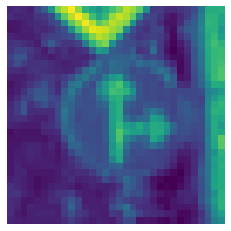

In [59]:
def grayscale(img):
    imge = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return imge

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


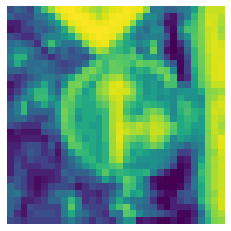

In [60]:
def equalize(img):
    imge = cv2.equalizeHist(img)
    return imge

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [61]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


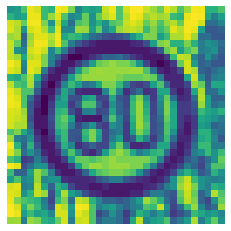

In [62]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [63]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [64]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


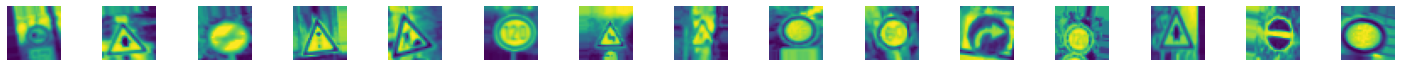

In [65]:
# for X_batch, y_batch in

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [66]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)
# create model

In [67]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [68]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [69]:
train_x = np.asarray(X_train)
train_y = np.asarray(y_train)
val_x = np.asarray(X_val)
val_y = np.asarray(y_val)

In [71]:
history = model.fit(datagen.flow(train_x, train_y, batch_size=50), steps_per_epoch=100,
                            epochs=10, validation_data=(val_x, val_y), shuffle = 1)

Epoch 1/10
100/100 [==============================] - 39s 386ms/step - loss: 3.4340 - accuracy: 0.0856 - val_loss: 2.7540 - val_accuracy: 0.2868
Epoch 2/10
100/100 [==============================] - 42s 423ms/step - loss: 2.3563 - accuracy: 0.3574 - val_loss: 1.2965 - val_accuracy: 0.6483
Epoch 3/10
100/100 [==============================] - 34s 342ms/step - loss: 1.5706 - accuracy: 0.5350 - val_loss: 0.8217 - val_accuracy: 0.7875
Epoch 4/10
100/100 [==============================] - 33s 329ms/step - loss: 1.2164 - accuracy: 0.6358 - val_loss: 0.5523 - val_accuracy: 0.8408
Epoch 5/10
100/100 [==============================] - 33s 331ms/step - loss: 0.9690 - accuracy: 0.7052 - val_loss: 0.3936 - val_accuracy: 0.8866
Epoch 6/10
100/100 [==============================] - 34s 345ms/step - loss: 0.8133 - accuracy: 0.7562 - val_loss: 0.3237 - val_accuracy: 0.8952
Epoch 7/10
100/100 [==============================] - 34s 340ms/step - loss: 0.7186 - accuracy: 0.7850 - val_loss: 0.2485 - val_ac

Text(0.5, 0, 'epoch')

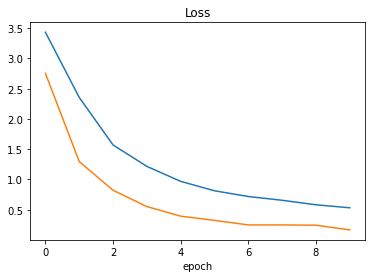

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

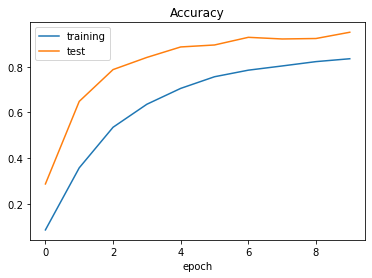

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [74]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.25882452726364136
Test accuracy: 0.9282660484313965


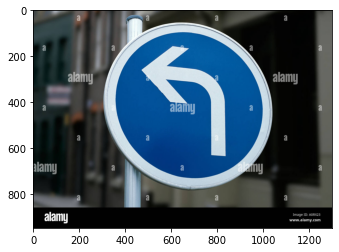

In [75]:
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
# 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


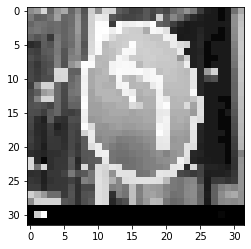

In [76]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [77]:
print("predicted sign: "+ str(model.predict(img)))

1/1 [==============================] - 0s 89ms/step
predicted sign: [[8.9362146e-07 2.7448218e-03 2.2723662e-02 9.3349699e-05 1.3911703e-06
  9.8164696e-03 7.1894065e-05 2.4111107e-02 1.1019546e-04 2.3865339e-06
  5.2137929e-04 3.5747213e-03 1.3380798e-02 4.0448920e-04 7.5921614e-04
  3.2472606e-05 2.1730859e-06 6.3658267e-06 3.6549082e-07 1.8200380e-08
  2.9493235e-06 2.6513477e-05 2.3943485e-08 1.1887246e-09 4.2212775e-07
  6.6113430e-06 1.1569174e-08 4.8365187e-08 2.1251013e-05 2.5745356e-07
  1.2749368e-03 5.2306309e-08 5.2360087e-07 6.1567776e-02 4.0707561e-01
  3.7185326e-01 1.1889809e-02 1.0641733e-04 3.8236026e-02 1.1990494e-05
  2.1161173e-02 4.9213696e-07 8.4056407e-03]]
